## 殘差分析


📊 經濟艙 - RandomForest：
  MSE = 0.0331, R² = 0.8920, RMSE = 0.1819, Adjusted R² = 0.8918

🔍 經濟艙 - RandomForest 殘差異常值共 333 筆，RSD ≈ 0.5459
✅ 已匯出：/Users/yuchingchen/Documents/專題/residual/residual_data/long_經濟艙_RandomForest_殘差異常值.csv

📊 經濟艙 - XGBoost：
  MSE = 0.0318, R² = 0.8961, RMSE = 0.1784, Adjusted R² = 0.8959

🔍 經濟艙 - XGBoost 殘差異常值共 233 筆，RSD ≈ 0.5353
✅ 已匯出：/Users/yuchingchen/Documents/專題/residual/residual_data/long_經濟艙_XGBoost_殘差異常值.csv


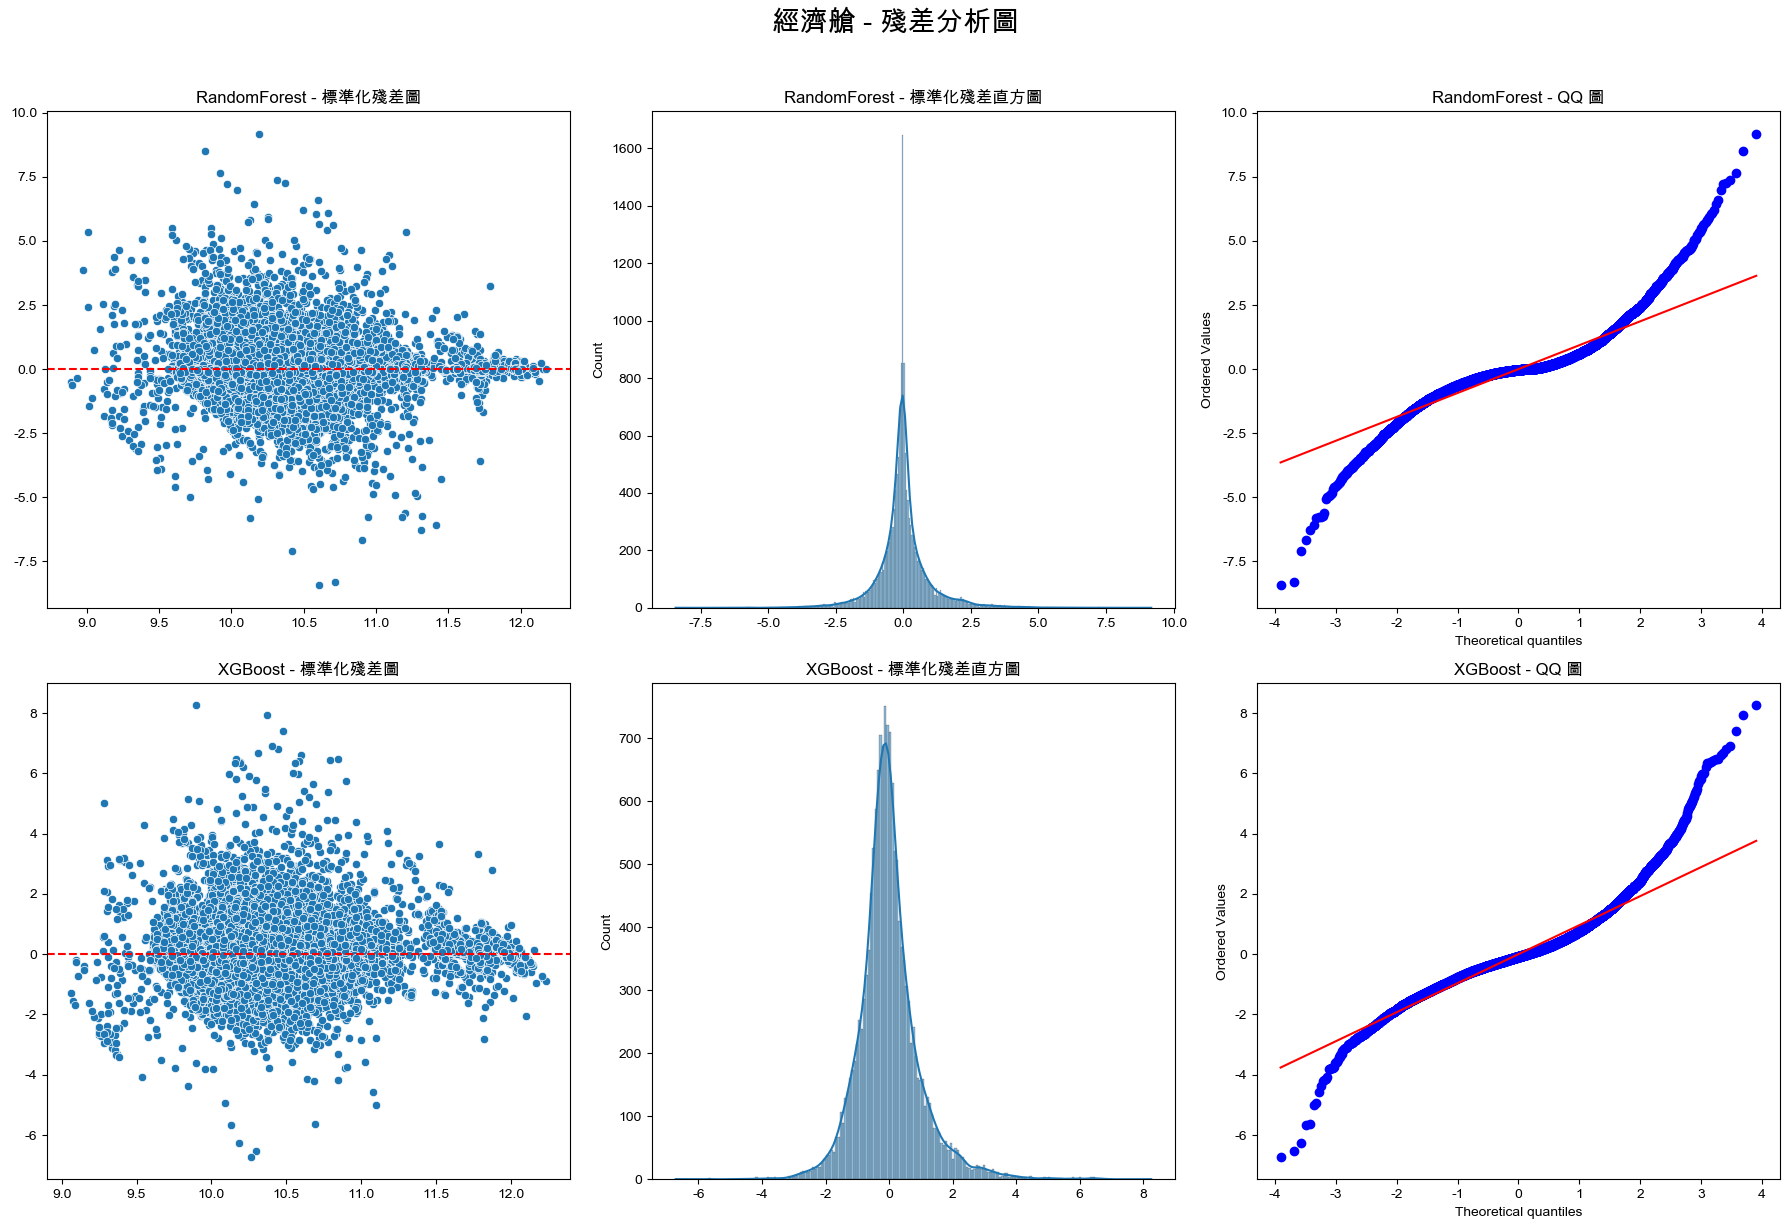


📊 商務艙 - RandomForest：
  MSE = 0.0162, R² = 0.8783, RMSE = 0.1272, Adjusted R² = 0.8780

🔍 商務艙 - RandomForest 殘差異常值共 259 筆，RSD ≈ 0.3816
✅ 已匯出：/Users/yuchingchen/Documents/專題/residual/residual_data/long_商務艙_RandomForest_殘差異常值.csv

📊 商務艙 - XGBoost：
  MSE = 0.0165, R² = 0.8762, RMSE = 0.1283, Adjusted R² = 0.8759

🔍 商務艙 - XGBoost 殘差異常值共 192 筆，RSD ≈ 0.3849
✅ 已匯出：/Users/yuchingchen/Documents/專題/residual/residual_data/long_商務艙_XGBoost_殘差異常值.csv


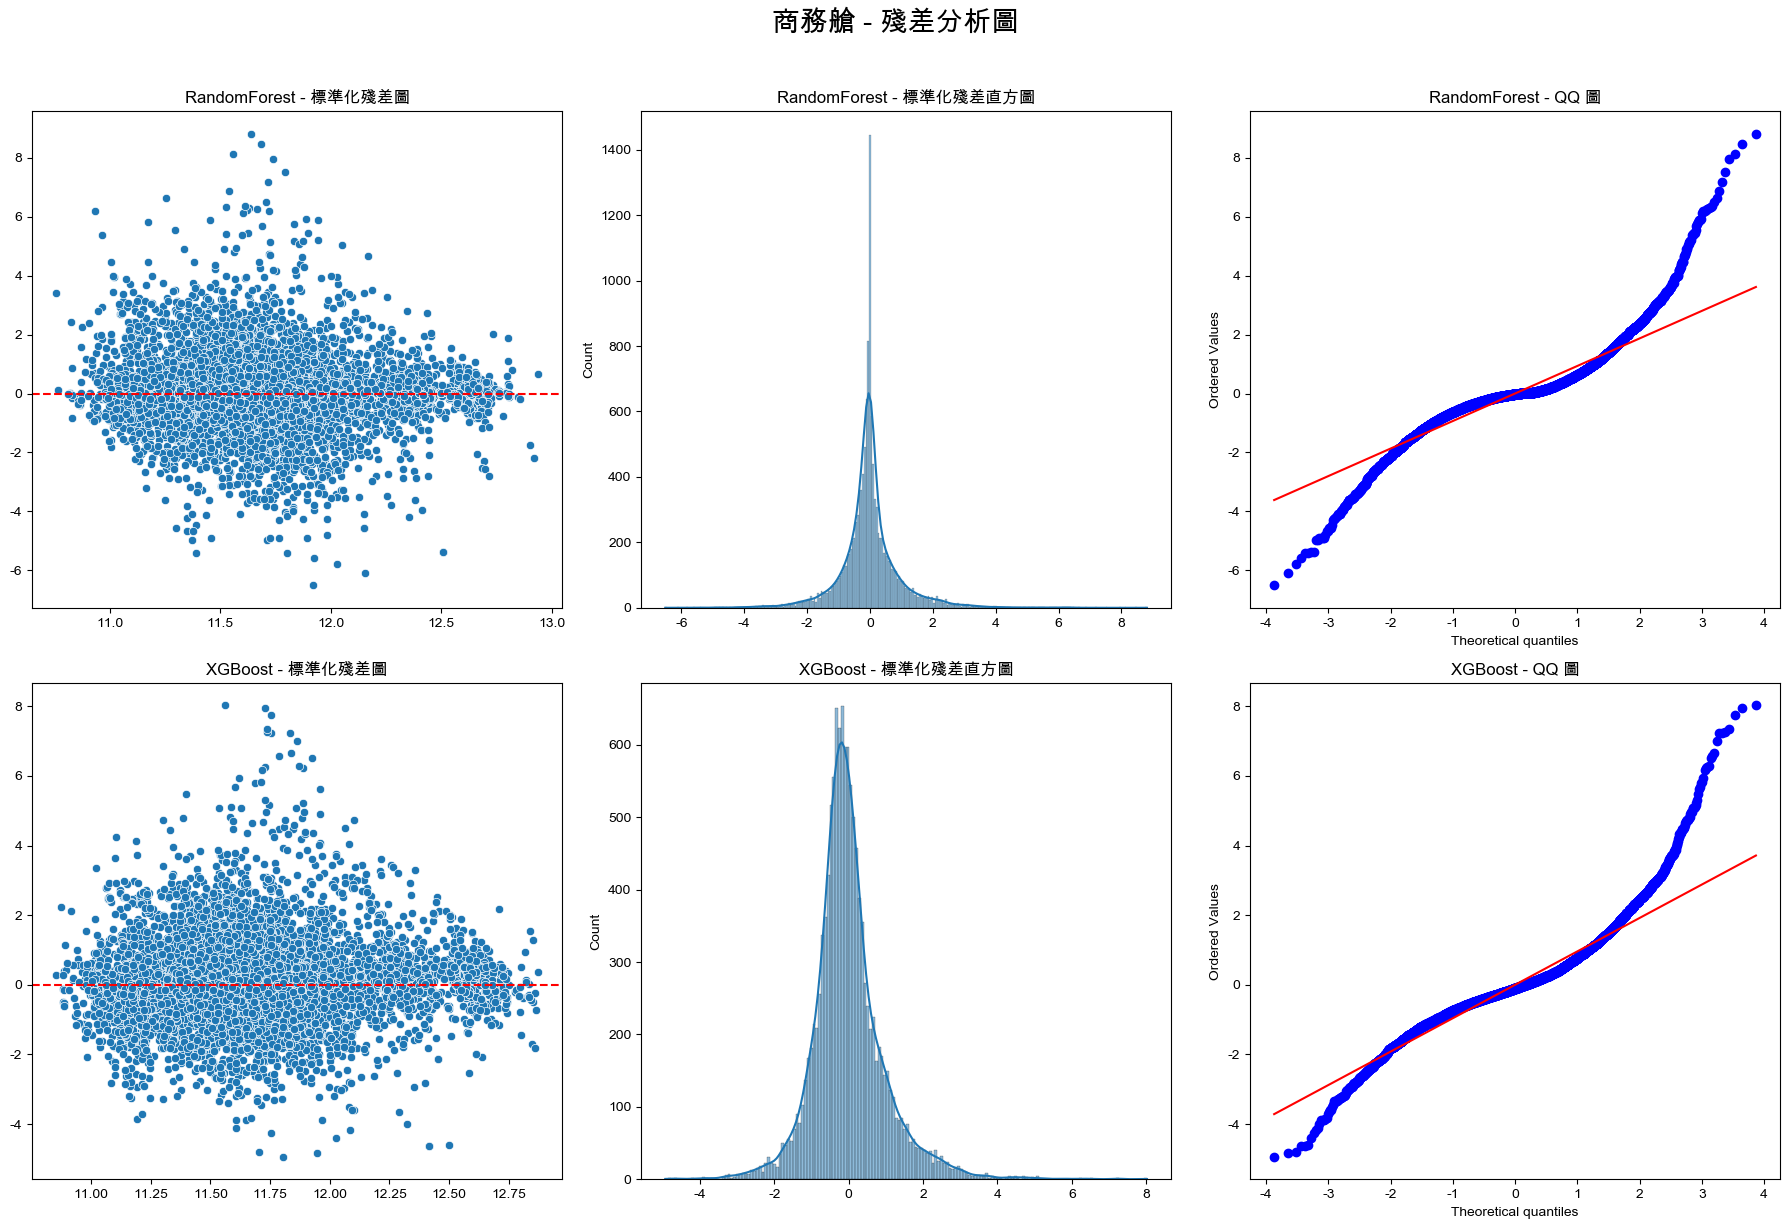

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 中文顯示設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# === 資料讀取 ===
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/long_flight.csv'
data = pd.read_csv(file_path)

# === 分艙等資料 ===
economy_data = data[data["艙等（主航段）"] == "經濟艙"]
business_data = data[data["艙等（主航段）"] == "商務艙"]

# === One-hot encoding ===
categorical_cols = ['出發時段', '出發機場代號', '抵達時段', '航空聯盟組合', '航空公司組合',
                   '航空聯盟', '停靠站數量', '機型分類', '假期', '飛行時間兩段分類', '是否為平日']
economy_data = pd.get_dummies(economy_data, columns=categorical_cols, drop_first=True)
business_data = pd.get_dummies(business_data, columns=categorical_cols, drop_first=True)

# === 數值欄位標準化 ===
num_cols = ['停留時間_分鐘', '實際飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
economy_data[num_cols] = scaler.fit_transform(economy_data[num_cols])
business_data[num_cols] = scaler.transform(business_data[num_cols])

# === 欄位一致化 ===
common_cols = list(set(economy_data.columns) & set(business_data.columns))
economy_data = economy_data[common_cols]
business_data = business_data[common_cols]

# === 特徵欄位 ===
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空聯盟組合_', '航空公司組合_',
                   '航空聯盟_', '停靠站數量_', '機型分類_', '假期_', '飛行時間兩段分類_', '是否為平日_']
econ_dummy_cols = [col for col in economy_data.columns if any(k in col for k in target_keywords)]
biz_dummy_cols = [col for col in business_data.columns if any(k in col for k in target_keywords)]
econ_features = econ_dummy_cols + ['停留時間_分鐘', '實際飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
biz_features = biz_dummy_cols + ['停留時間_分鐘', '實際飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# === 建模 ===
def run_model(seed, X, y, cabin_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    test_index = y_test.index
    n_test = len(y_test)
    p = X.shape[1]
    result = {}

    # RandomForest
    rf = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    result['RandomForest'] = {
        'MSE': mean_squared_error(y_test, y_pred_rf),
        'R2': r2_score(y_test, y_pred_rf),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        'Adjusted_R2': 1 - (1 - r2_score(y_test, y_pred_rf)) * (n_test - 1) / (n_test - p - 1),
        'y_test': y_test.values,
        'y_pred': y_pred_rf,
        'index': test_index
    }

    # XGBoost
    xgb = XGBRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    result['XGBoost'] = {
        'MSE': mean_squared_error(y_test, y_pred_xgb),
        'R2': r2_score(y_test, y_pred_xgb),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        'Adjusted_R2': 1 - (1 - r2_score(y_test, y_pred_xgb)) * (n_test - 1) / (n_test - p - 1),
        'y_test': y_test.values,
        'y_pred': y_pred_xgb,
        'index': test_index
    }

    return cabin_type, result

# === 殘差分析 ===
def detect_outliers(y_test, y_pred, model_name, cabin_type, index, full_data):
    residuals = y_test - y_pred
    rsd = np.sqrt(np.sum(residuals**2) / (len(residuals) - 1))
    threshold = 3 * rsd
    outlier_idx = np.where(np.abs(residuals) > threshold)[0]
    original_idx = index[outlier_idx]
    print(f"\n🔍 {cabin_type} - {model_name} 殘差異常值共 {len(outlier_idx)} 筆，RSD ≈ {threshold:.4f}")
    outlier_data = full_data.loc[original_idx].copy()
    outlier_data['y_test_log'] = y_test[outlier_idx]
    outlier_data['y_pred_log'] = y_pred[outlier_idx]
    outlier_data['residual_log'] = residuals[outlier_idx]
    outlier_data['預測價格'] = np.exp(y_pred[outlier_idx])
    outlier_data['實際價格'] = np.exp(y_test[outlier_idx])
    outlier_data['相對誤差 (%)'] = np.abs(outlier_data['預測價格'] - outlier_data['實際價格']) / outlier_data['實際價格'] * 100
    if 'residual_log' in outlier_data.columns:
        outlier_data = outlier_data.sort_values(by='residual_log')
    return outlier_data

def analyze_and_plot_grid(all_results, cabin_type, full_data, models=['RandomForest', 'XGBoost']):
    fig, axes = plt.subplots(len(models), 3, figsize=(18, 6 * len(models)))
    fig.suptitle(f"{cabin_type} - 殘差分析圖", fontsize=20, y=1.02)

    for i, model in enumerate(models):
        _, res = all_results[0]
        y_test = res[model]['y_test']
        y_pred = res[model]['y_pred']
        index = res[model]['index']
        residuals = y_test - y_pred
        std_res = (residuals - np.mean(residuals)) / np.std(residuals)

        sns.scatterplot(ax=axes[i, 0], x=y_pred, y=std_res)
        axes[i, 0].axhline(0, color='red', linestyle='--')
        axes[i, 0].set_title(f"{model} - 標準化殘差圖")

        sns.histplot(ax=axes[i, 1], data=std_res, kde=True)
        axes[i, 1].set_title(f"{model} - 標準化殘差直方圖")

        stats.probplot(std_res, dist="norm", plot=axes[i, 2])
        axes[i, 2].set_title(f"{model} - QQ 圖")

        print(f"\n📊 {cabin_type} - {model}：")
        print(f"  MSE = {res[model]['MSE']:.4f}, R² = {res[model]['R2']:.4f}, RMSE = {res[model]['RMSE']:.4f}, Adjusted R² = {res[model]['Adjusted_R2']:.4f}")

        outliers = detect_outliers(y_test, y_pred, model, cabin_type, index, full_data)
        outliers.to_csv(f"/Users/yuchingchen/Documents/專題/residual/residual_data/long_{cabin_type}_{model}_殘差異常值.csv", index=False, encoding='utf-8-sig')
        print(f"✅ 已匯出：/Users/yuchingchen/Documents/專題/residual/residual_data/long_{cabin_type}_{model}_殘差異常值.csv")

    plt.tight_layout()
    plt.show()

# === 執行 ===
seeds = [123]
econ_result = Parallel(n_jobs=-1)(delayed(run_model)(s, economy_data[econ_features], economy_data["平均價格_log"], "經濟艙") for s in seeds)
biz_result = Parallel(n_jobs=-1)(delayed(run_model)(s, business_data[biz_features], business_data["平均價格_log"], "商務艙") for s in seeds)

analyze_and_plot_grid(econ_result, "經濟艙", data[data["艙等（主航段）"] == "經濟艙"])
analyze_and_plot_grid(biz_result, "商務艙", data[data["艙等（主航段）"] == "商務艙"])